Measure the approximate ICL in each cutout by measuring all light with magnitude over 26.5 mag threshold

## Preliminary thresholding and measuring

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Pixel value corresponding to a 26.5 mag threshold
# Formula and flux mag 0 from the headers of the fits files
threshold = 63095734448.0194 / (10**(26.5/2.5))

In [3]:
# Load the cutouts
cutouts = h5py.File('../processed/cutouts.hdf')

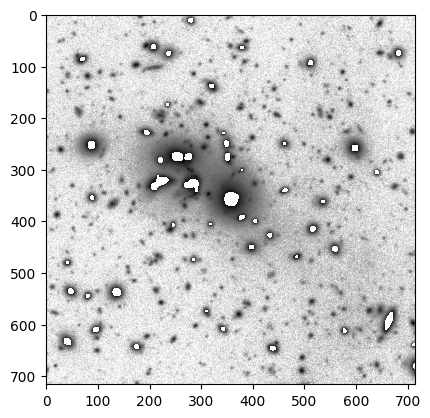

In [4]:
# Display a cutout with the threshold applied
cutout = np.array(cutouts['0']['HDU0']['DATA'])
masked_cutout = cutout.copy()
masked_cutout[cutout > threshold] = np.nan

stddev = 0.017359
plt.imshow(np.arcsinh(np.clip(masked_cutout, a_min=0.0, a_max=10.0) / stddev), cmap='gray_r')
plt.show()

In [5]:
# Measure remaining light in the image
icl = np.sum(masked_cutout[~np.isnan(masked_cutout)])
print(icl)
icl_frac = icl / np.sum(cutout)
print(icl_frac)

25690.176
0.68267834


In [6]:
# Calculate this for every cutout
fracs = np.zeros(len(list(cutouts.keys())))
for key in cutouts.keys():
    cutout = np.array(cutouts[key]['HDU0']['DATA'])
    masked_cutout = cutout.copy()
    masked_cutout[cutout > threshold] = np.nan

    icl = np.sum(masked_cutout[~np.isnan(masked_cutout)])
    icl_frac = icl / np.sum(cutout)
    fracs[int(key)] = icl_frac
    

In [7]:
# Top and bottom 5 ICL fractions
ranked = np.argsort(fracs)
top_5 = ranked[-5:][::-1]
bottom_5 = ranked[:5]
print(list(zip(top_5, fracs[top_5])))
print(list(zip(bottom_5, fracs[bottom_5])))

[(1381, 0.9069186449050903), (277, 0.9035166501998901), (1390, 0.9001319408416748), (1119, 0.8964278697967529), (2142, 0.889991044998169)]
[(2279, 0.09637250751256943), (592, 0.15408539772033691), (571, 0.15572555363178253), (1051, 0.16246673464775085), (734, 0.18891967833042145)]


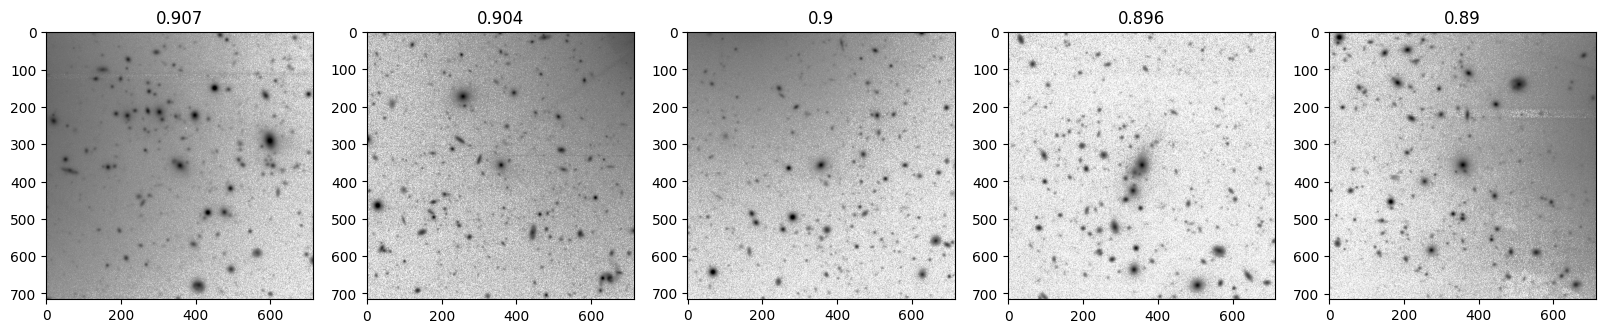

In [8]:
# Plot the top 5 clusters
plt.figure(figsize=(20,4))
for i, idx in enumerate(top_5):
    plt.subplot(1, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    plt.imshow(np.arcsinh(np.clip(cutout, a_min=0.0, a_max=10.0) / stddev), cmap='gray_r')
    plt.title(round(fracs[idx], 3))

plt.show()

Problem: all of these don't actually have that much ICL, the calculation is getting contaminated by the bright backgrounds in these images. Also, we shouldn't be measuring ICL across the whole cutout because the clusters do not actually extend that far.

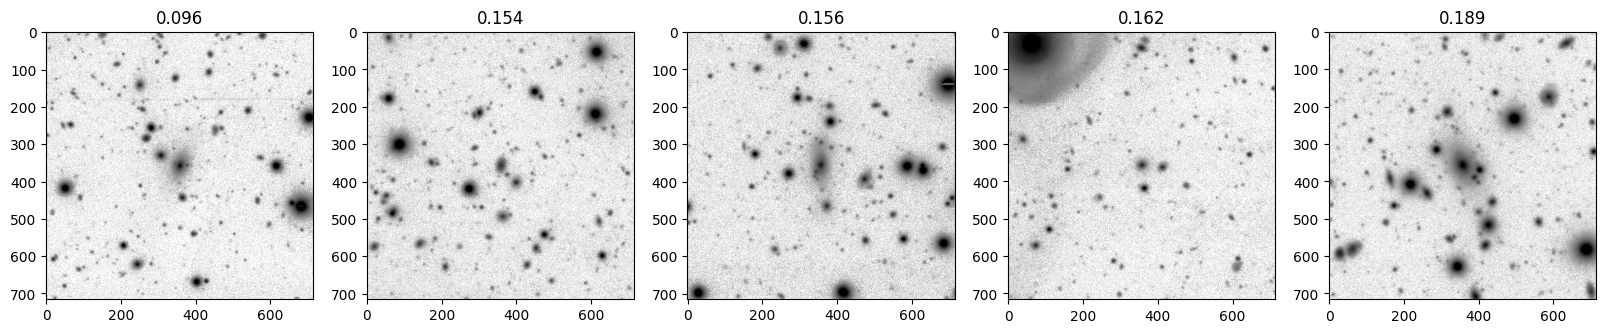

In [9]:
# Plot the bottom 5 clusters
plt.figure(figsize=(20,4))
for i, idx in enumerate(bottom_5):
    plt.subplot(1, 5, i+1)
    cutout = cutouts[str(idx)]['HDU0']['DATA']
    plt.imshow(np.arcsinh(np.clip(cutout, a_min=0.0, a_max=10.0) / stddev), cmap='gray_r')
    plt.title(round(fracs[idx], 3))

plt.show()

## Background subtraction
Need to get rid of the bright backgrounds in the images that is being counted as ICL in the calculation.

In [31]:
# Convenience function for plotting the images
def stretch(img):
    return np.arcsinh(np.clip(img, a_min=0.0, a_max=10.0) / stddev)

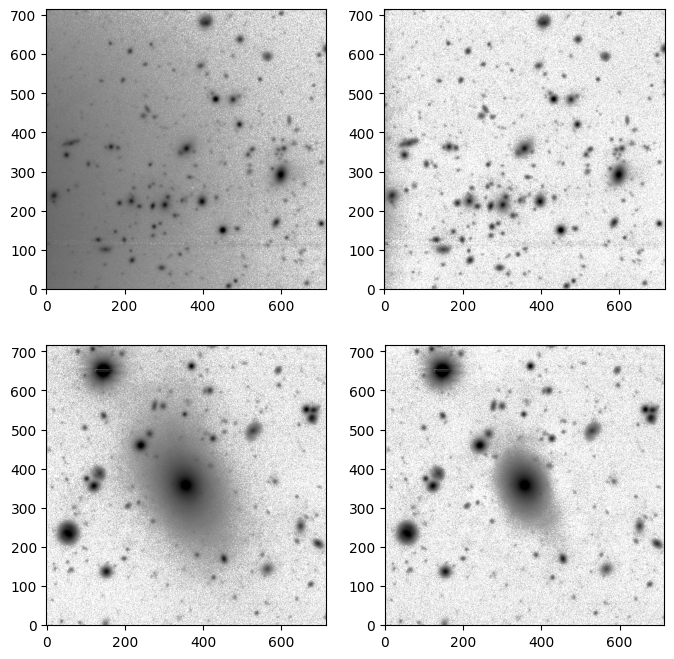

In [34]:
from photutils.background import Background2D

cutout = np.array(cutouts['1381']['HDU0']['DATA'])
bkg = Background2D(cutout, box_size=50)
img1 = stretch(cutout-bkg.background)

cutout2 = np.array(cutouts['828']['HDU0']['DATA'])
bkg = Background2D(cutout2, box_size=50)
img2 = stretch(cutout2-bkg.background)

plt.figure(figsize=(8,8))
plt.subplot(221)
plt.imshow(stretch(cutout), origin='lower', cmap='gray_r')
plt.subplot(222)
plt.imshow(img1, origin='lower', cmap='gray_r')
plt.subplot(223)
plt.imshow(stretch(cutout2), origin='lower', cmap='gray_r')
plt.subplot(224)
plt.imshow(img2, origin='lower', cmap='gray_r')
plt.show()

This works well for the images with a bright gradient across the whole image, but when there is a large amount of extended ICL it gets subtracted, which is not what we want. 

A good compromise would be a modified version where the background is estimated just with the edges of the image. This would get rid of the bright light that extends over the whole image, while ignoring any diffuse light in the centre of the image.

In [35]:
# Get the coordinates of the mesh edges
box_size = 50

size_x = bkg.background_mesh.shape[0]
size_y = bkg.background_mesh.shape[1]
xvals = np.arange(0, size_x)
yvals = np.arange(0, size_y)

box_cen = (box_size - 1) / 2.0

top = np.column_stack((xvals, (size_x - 1) * np.ones(size_x, dtype=int)))
bottom = np.column_stack((xvals, np.zeros(size_x, dtype=int)))
left = np.column_stack((np.zeros(size_y, dtype=int), yvals))
right = np.column_stack(((size_y - 1) * np.ones(size_y, dtype=int), yvals))

square = np.unique(np.concatenate((top, bottom, left, right), axis=0), axis=0)
real_square = box_size * square + box_cen

In [17]:
# Get the values from the mesh corresponding to the coordinates
vals = np.array([bkg.background_mesh[tuple(c)] for c in square])

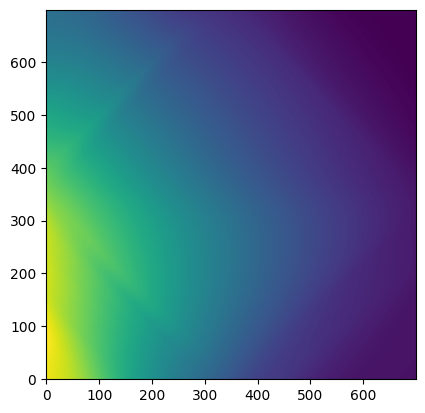

In [18]:
# Construct the interpolator and estimate the background
from scipy.interpolate import CloughTocher2DInterpolator
interp = CloughTocher2DInterpolator(real_square, vals)
x = np.arange(np.min(real_square), np.max(real_square))
y = np.arange(np.min(real_square), np.max(real_square))
x, y = np.meshgrid(x, y) # 2D grid
z = interp(x, y).T
plt.imshow(z, origin='lower')

There is a weird diamond artifact in the image, but it's probably good enough

In [19]:
# Expand the image to the correct size
edge_widths = (
    (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
     int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
    (int(np.abs(cutout.shape[1] - z.shape[1])/2),
     int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
)

bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

In [21]:
# Make a function for the background subtraction process
def background_estimate(cutout):
    # Run photutil's Background2D for the low resolution grid
    bkg_initial = Background2D(cutout, box_size=50)
    mesh = bkg_initial.background_mesh

    # Extract just the edges of the mesh
    size_x = mesh.shape[0]
    size_y = mesh.shape[1]
    xvals = np.arange(0, size_x)
    yvals = np.arange(0, size_y)

    box_cen = (box_size - 1) / 2.0

    top = np.column_stack((xvals, (size_x - 1) * np.ones(size_x, dtype=int)))
    bottom = np.column_stack((xvals, np.zeros(size_x, dtype=int)))
    left = np.column_stack((np.zeros(size_y, dtype=int), yvals))
    right = np.column_stack(((size_y - 1) * np.ones(size_y, dtype=int), yvals))

    # Indices of edges
    square = np.unique(np.concatenate((top, bottom, left, right), axis=0), axis=0)
    # Pixel locations of centres of edge boxes
    real_square = box_size * square + box_cen

    # Get the values from the mesh corresponding to the coordinates
    vals = np.array([mesh[tuple(c)] for c in square])

    # Interpolate between the edges of the square
    interp = CloughTocher2DInterpolator(real_square, vals)
    x = np.arange(np.min(real_square), np.max(real_square))
    y = np.arange(np.min(real_square), np.max(real_square))
    x, y = np.meshgrid(x, y) # 2D grid
    z = interp(x, y).T

    # Expand the image to the correct size
    edge_widths = (
        (int(np.abs(cutout.shape[0] - z.shape[0])/2), 
        int(np.ceil(np.abs(cutout.shape[0] - z.shape[0])/2))),
        (int(np.abs(cutout.shape[1] - z.shape[1])/2),
        int(np.ceil(np.abs(cutout.shape[1] - z.shape[1])/2)))
    )
    bkg = np.pad(z, pad_width=edge_widths, mode='reflect')

    # Return background estimation
    return bkg

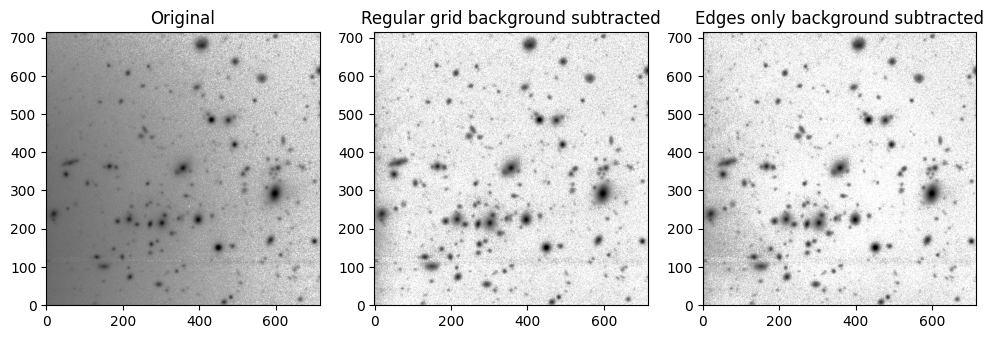

In [22]:
# Compare the custom background estimation to the grid background estimation
cutout = np.array(cutouts['1381']['HDU0']['DATA'])
bkg1 = Background2D(cutout, box_size=50)
bkg2 = background_estimate(cutout)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(stretch(cutout), cmap='gray_r', origin='lower')
plt.title('Original')
plt.subplot(132)
plt.imshow(stretch(cutout-bkg1.background), cmap='gray_r', origin='lower')
plt.title('Regular grid background subtracted')
plt.subplot(133)
plt.imshow(stretch(cutout-bkg2), cmap='gray_r', origin='lower')
plt.title('Edges only background subtracted')
plt.show()

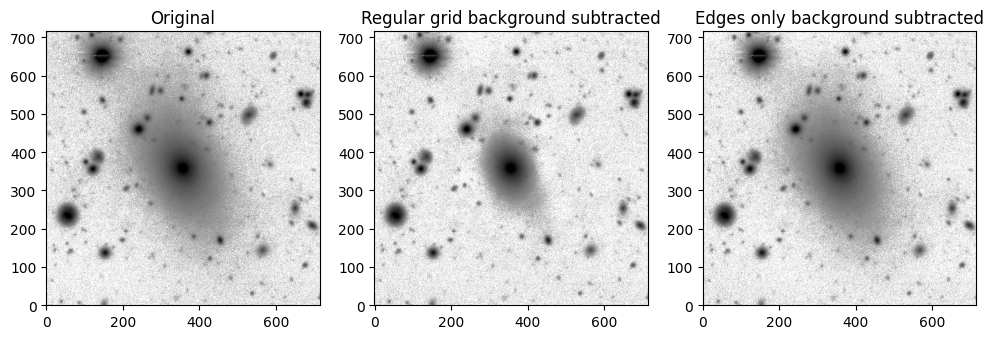

In [23]:
# Compare the custom background estimation to the grid background estimation
cutout = np.array(cutouts['828']['HDU0']['DATA'])
bkg1 = Background2D(cutout, box_size=50)
bkg2 = background_estimate(cutout)

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(stretch(cutout), cmap='gray_r', origin='lower')
plt.title('Original')
plt.subplot(132)
plt.imshow(stretch(cutout-bkg1.background), cmap='gray_r', origin='lower')
plt.title('Regular grid background subtracted')
plt.subplot(133)
plt.imshow(stretch(cutout-bkg2), cmap='gray_r', origin='lower')
plt.title('Edges only background subtracted')
plt.show()

## Adjust aperture with redshift
Want to measure ICL within a radius of 130kpc

In [24]:
# Load the redshifts from the table
from astropy.io import ascii

tbl = ascii.read('../processed/camira_final.tbl', 
                 names=['ID', 'Name', 'RA', 'Dec', 'z', 'Richness', 'BCG z'])
z = tbl['z']

cutouts = h5py.File('../processed/cutouts.hdf')

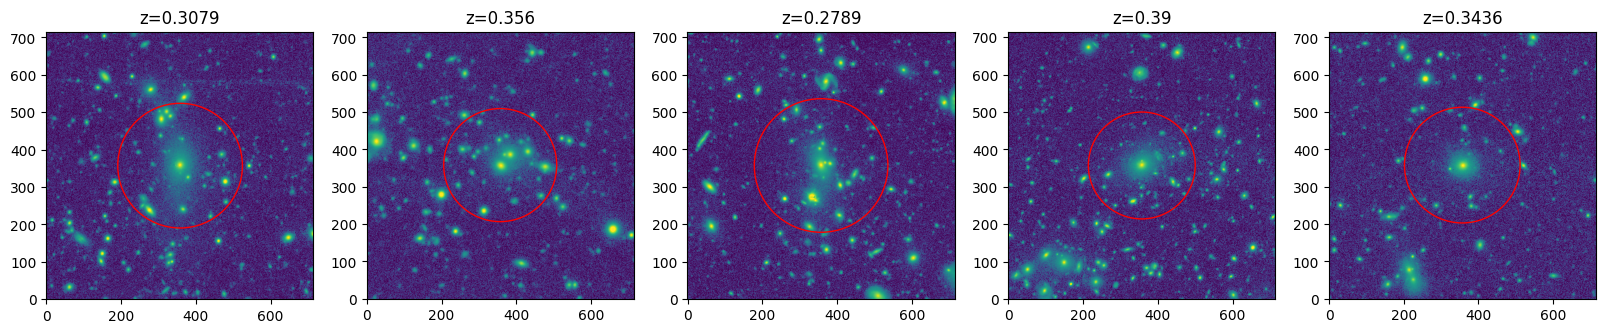

In [25]:
import random
from astropy.cosmology import FlatLambdaCDM
from matplotlib.patches import Circle

# Select a few random images and draw a circle corresponding to 130kpc
idxs = random.sample(list(range(len(cutouts.keys()))), 5)
zs = z[idxs]

cosmo = FlatLambdaCDM(H0=68.4, Om0=0.301)
arcsec_to_px = 1/0.168

plt.figure(figsize=(20,4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = stretch(cutouts[str(idxs[i])]['HDU0']['DATA'])
    plt.imshow(img, origin='lower')
    radius = (cosmo.arcsec_per_kpc_proper(zs[i]) * 130).value * arcsec_to_px
    circ = Circle((img.shape[0] // 2, img.shape[1] // 2), radius=radius, fill=False, color='red')
    ax = plt.gca()
    ax.add_patch(circ)
    ax.set_title(f'z={zs[i]}')
plt.show()

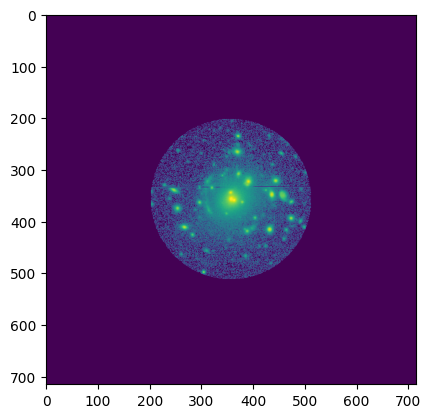

In [26]:
# Mask an image according to the circle
cutout = cutouts['2376']['HDU0']['DATA']
img = stretch(cutout)
centre = (img.shape[1] // 2, img.shape[0] // 2)
Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
dist_from_center = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

mask = dist_from_center <= radius
plt.imshow(img * mask)

In [37]:
# Calculate the ICL before and after the masking process
cutout = np.array(cutouts['2376']['HDU0']['DATA'])
threshold = 63095734448.0194 / (10**(26.5/2.5))
icl_frac_before = np.sum(cutout[cutout < threshold]) / np.sum(cutout)

centre = (img.shape[1] // 2, img.shape[0] // 2)
Y, X = np.ogrid[:img.shape[0], :img.shape[1]]
dist_from_center = np.sqrt((X-centre[0])**2 + (Y-centre[1])**2)

mask = dist_from_center <= radius

icl_frac_after = np.sum((cutout*mask)[cutout*mask < threshold]) / np.sum(cutout*mask)

print(icl_frac_before, icl_frac_after)

0.7518257 0.7059221
